## 02: Data Preparation

1. Here we construct our dataset for use in the experiment.

In [1]:
# import required libraries
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import random
import libs.utils as utils
import libs.bounding_box as bounding_box
import libs.patch_tools as patch_tools
import libs.data_prep as data_prep
import libs.train_test_split as tts
import libs.importing as importing
import libs.render as render
import libs.stats as stats
import libs.patch_tools as patch_tools
from importlib import reload


# set the random seed for we always get the same results (for now)
random.seed(42)


In [3]:
# GENERATE DATASET ID
exp_id = utils.short_id()
# use same data
exp_id = '51c5ca37'
print('ID: {}'.format(exp_id))

ID: 51c5ca37


In [4]:
# COPY DATA and SETUP EXPERIMENT
base_dir = '../source_dataset/all_v1'
data_prep.setup_experiment(base_dir, exp_id)

In [25]:
# 2-CLASS PROBLEM : Benign v. Papilloma

# SETUP : GET ALL CONTOURS
roi_df = pd.read_csv(os.path.join(exp_id, 'contours.csv'))
roi_2class = roi_df.copy()

# merge dysplasias and carcinomas
roi_2class.loc[roi_2class['label'] == 4, 'label'] = 3

train2bp_df, test2bp_df, val2bp_df = tts.train_test_validation_split(roi_2class, classes=[1,2,3], samples=3)

# SAVE : save the results
train2bp_df.to_csv(os.path.join(exp_id, 'contours_train.csv'), index=False)
test2bp_df.to_csv(os.path.join(exp_id, 'contours_test.csv'), index=False)
val2bp_df.to_csv(os.path.join(exp_id, 'contours_val.csv'), index=False)

n: 97
distribution: [1 2 3] [30 20 47]
classes: [1 2 3], samples_per_class: 3
train-n: 79
test-n: 9
val-n: 9


In [15]:
# OR IF we've already run this notebook before we can just load the data
train2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_train.csv'))
test2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_test.csv'))
val2bp_df = pd.read_csv(os.path.join(exp_id, 'contours_val.csv'))

In [26]:
# LOG : show all the contours we dumped and those we are using
#       these are logged at: 
#       [dumped] ./exp_id/log/eleminated_contours
#       [kept]   ./exp_id/log/experiment_contours
data_prep.show_contours_for_experiment(exp_id, roi_df, roi_2class)

total contours: 97
eliminated contours: 0
kept contours: 97


Empty DataFrame
Columns: [image_id, id, name, label]
Index: []

In [27]:
# TRAIN : data setup
#       : creates a directory ./exp_id/train/  where all the images and contours for training are stored
#       : creates a directory ./exp_id/train/log/info, where the contours and labels for the training set are stored as images for debugging purposes. 
train_df  = pd.read_csv(os.path.join(exp_id, 'contours_train.csv'))
data_prep.setup_component(exp_id, train_df, 'train')
data_prep.log_component_info(os.path.join(exp_id, 'train'))

In [28]:
# TEST : data setup
#       : creates a directory ./exp_id/test/  where all the images and contours for test data are stored
#       : creates a directory ./exp_id/test/log/info, where the contours and labels for the test set are stored as images for debugging purposes.
test_df = pd.read_csv(os.path.join(exp_id, 'contours_test.csv'))
data_prep.setup_component(exp_id, test_df, 'test')
data_prep.log_component_info(os.path.join(exp_id, 'test'))

In [29]:
# VALIDATION : data setup
#       : creates a directory ./exp_id/val/  where all the images and contours for validation data are stored
#       : creates a directory ./exp_id/val/log/info, where the contours and labels for the validation set are stored as images for debugging purposes.
val_df = pd.read_csv(os.path.join(exp_id, 'contours_val.csv'))
data_prep.setup_component(exp_id, val_df, 'val')
data_prep.log_component_info(os.path.join(exp_id, 'val'))

In [30]:
# GENERATE PATCHES : training data
#                    logs information to ./exp_id/train/log/setup_patches, where it shows patches on the image before and after removal

# threshold : the percentage a patch needs to overlap with the contour polygon in order to not be discarded
# patch_overlap : the shift size, should be a value which generates a factor of 64 for instance 0.5*64 = 32, or 0.25 * 64 = 16, etc.
train_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'train'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

# inspect the structure of our patches.csv file
display(train_patches_df.head())

# see how many training patches we have 
print('count: {}'.format(len(train_patches_df)))

image_id contour_id  patch_id    patch_name    x    y label_id
0  hgv-44a1f2e3   2dd43905  98aee12a  98aee12a.jpg  762  674        3
1  hgv-44a1f2e3   2dd43905  9adad738  9adad738.jpg  794  674        3
2  hgv-44a1f2e3   2dd43905  97a3e9dd  97a3e9dd.jpg  826  674        3
3  hgv-44a1f2e3   2dd43905  f17ca4b5  f17ca4b5.jpg  858  674        3
4  hgv-44a1f2e3   2dd43905  044c0135  044c0135.jpg  890  674        3

count: 4217


In [31]:
# GENERATE PATCHES : test data
#                    logs information to ./exp_id/test/log/setup_patches, where it shows patches on the image before and after removal
test_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'test'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

display(test_patches_df.head())
print('count: {}'.format(len(test_patches_df)))

image_id contour_id  patch_id    patch_name    x    y label_id
0  hgv-2d4a6a46   76f536d8  6a0b94e0  6a0b94e0.jpg  910  712        1
1  hgv-2d4a6a46   76f536d8  27c8de46  27c8de46.jpg  942  712        1
2  hgv-2d4a6a46   76f536d8  0f73cf3d  0f73cf3d.jpg  814  744        1
3  hgv-2d4a6a46   76f536d8  a19a7970  a19a7970.jpg  846  744        1
4  hgv-2d4a6a46   76f536d8  7ef87d5d  7ef87d5d.jpg  878  744        1

count: 352


In [32]:
# GENERATE PATCHES : validation data
#                    logs information to ./exp_id/val/log/setup_patches, where it shows patches on the image before and after removal
val_patches_df = data_prep.setup_patches_for(os.path.join(exp_id, 'val'), patch_size = 64, patch_overlap = 0.5, threshold = 0.5)

display(val_patches_df.head())
print('count: {}'.format(len(val_patches_df)))

image_id contour_id  patch_id    patch_name    x    y label_id
0  hgv-2cdb69f6   2b225cd3  da8c9a50  da8c9a50.jpg  561  141        2
1  hgv-2cdb69f6   2b225cd3  f4341214  f4341214.jpg  593  141        2
2  hgv-2cdb69f6   2b225cd3  77948147  77948147.jpg  593  173        2
3  hgv-2cdb69f6   2b225cd3  a888185b  a888185b.jpg  625  173        2
4  hgv-2cdb69f6   2b225cd3  21f8656b  21f8656b.jpg  593  205        2

count: 535


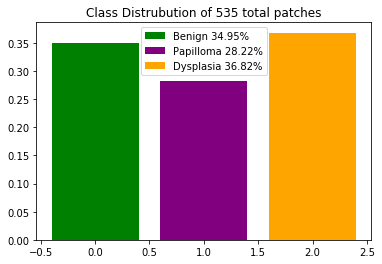

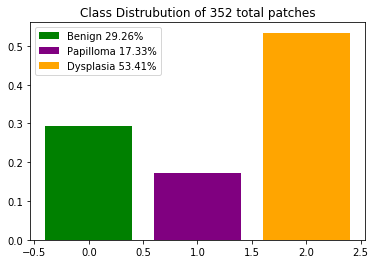

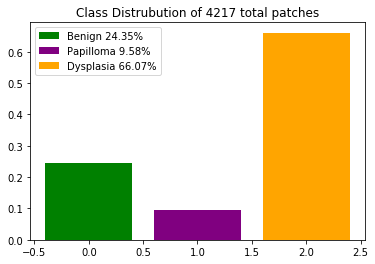

In [33]:
# BEFORE FILTERING PATCHES LOOK AT PATCH DISTRIBUTION
stats.plot_label_distribution(val_patches_df, labels=[1,2,3], label_key='label_id')
stats.plot_label_distribution(test_patches_df, labels=[1,2,3], label_key='label_id')
stats.plot_label_distribution(train_patches_df, labels=[1,2,3], label_key='label_id')

In [34]:
# FILTER PATCHES : some patches have way too much light or are just bad quality
#                  here we filter out patches which are so specular they contain very little information
#                  see: filtered patches are drawn onto the image at : ./exp_id/{train,test,val}/log/filter_highlight_patches - useful for debugging

train_dir = os.path.join(exp_id, 'train')
test_dir = os.path.join(exp_id, 'test')
val_dir = os.path.join(exp_id, 'val')

data_prep.filter_highlight_patches_for(train_dir, patch_size = 64, threshold=0.5)
data_prep.filter_highlight_patches_for(test_dir, patch_size = 64, threshold=0.5)
data_prep.filter_highlight_patches_for(val_dir, patch_size = 64, threshold=0.5)


bad patches: 58
before: 4217
cleaned: 4159
bad patches: 0
before: 352
cleaned: 352
bad patches: 0
before: 535
cleaned: 535


image_id contour_id  patch_id    patch_name    x    y  label_id
0    hgv-2cdb69f6   2b225cd3  da8c9a50  da8c9a50.jpg  561  141         2
1    hgv-2cdb69f6   2b225cd3  f4341214  f4341214.jpg  593  141         2
2    hgv-2cdb69f6   2b225cd3  77948147  77948147.jpg  593  173         2
3    hgv-2cdb69f6   2b225cd3  a888185b  a888185b.jpg  625  173         2
4    hgv-2cdb69f6   2b225cd3  21f8656b  21f8656b.jpg  593  205         2
5    hgv-2cdb69f6   2b225cd3  eb9e0c3e  eb9e0c3e.jpg  625  205         2
6    hgv-2cdb69f6   2b225cd3  67bda2dd  67bda2dd.jpg  657  205         2
7    hgv-2cdb69f6   2b225cd3  ddaf27ec  ddaf27ec.jpg  625  237         2
8    hgv-2cdb69f6   2b225cd3  ba4a96a9  ba4a96a9.jpg  657  237         2
9    hgv-2cdb69f6   2b225cd3  bca0920a  bca0920a.jpg  689  237         2
10   hgv-2cdb69f6   2b225cd3  53ed26d4  53ed26d4.jpg  657  269         2
11   hgv-2cdb69f6   2b225cd3  51a09550  51a09550.jpg  689  269         2
12   hgv-2cdb69f6   2b225cd3  bee78095  bee78095.jpg  721  269         2
13   hgv-2cdb69f6   2b225cd3  fa6eecb8  fa6eecb8.jpg  753  269         2
14   hgv-2cdb69f6   2b225cd3  8eb3891a  8eb3891a.jpg  657  301         2
15   hgv-2cdb69f6   2b225cd3  7b8a5d1b  7b8a5d1b.jpg  689  301         2
16   hgv-2cdb69f6   2b225cd3  5af9ed08  5af9ed08.jpg  721  301         2
17   hgv-2cdb69f6   2b225cd3  4fe6b79a  4fe6b79a.jpg  753  301         2
18   hgv-2cdb69f6   2b225cd3  4d14290e  4d14290e.jpg  785  301         2
19   hgv-2cdb69f6   2b225cd3  b3829966  b3829966.jpg  689  333         2
20   hgv-2cdb69f6   2b225cd3  76797a7f  76797a7f.jpg  721  333         2
21   hgv-2cdb69f6   2b225cd3  33081a6c  33081a6c.jpg  753  333         2
22   hgv-2cdb69f6   2b225cd3  6ddaa3ac  6ddaa3ac.jpg  785  333         2
23   hgv-2cdb69f6   2b225cd3  7a20a7fc  7a20a7fc.jpg  689  365         2
24   hgv-2cdb69f6   2b225cd3  ade3d5b3  ade3d5b3.jpg  721  365         2
25   hgv-2cdb69f6   2b225cd3  f1b0f538  f1b0f538.jpg  753  365         2
26   hgv-2cdb69f6   2b225cd3  ef2dfa65  ef2dfa65.jpg  785  365         2
27   hgv-2cdb69f6   2b225cd3  0dc55e83  0dc55e83.jpg  817  365         2
28   hgv-2cdb69f6   2b225cd3  c1f1f113  c1f1f113.jpg  849  365         2
29   hgv-2cdb69f6   2b225cd3  4cc66f09  4cc66f09.jpg  721  397         2
..            ...        ...       ...           ...  ...  ...       ...
505  odi-a981441f   415e5e1d  253dd2aa  253dd2aa.jpg  124  270         2
506  odi-a981441f   415e5e1d  72f31f8c  72f31f8c.jpg  124  302         2
507  odi-a981441f   415e5e1d  43198288  43198288.jpg  156  302         2
508  odi-a981441f   415e5e1d  e4e91e22  e4e91e22.jpg  124  334         2
509  odi-a981441f   415e5e1d  b3476c6b  b3476c6b.jpg  156  334         2
510  odi-a981441f   415e5e1d  79407ddf  79407ddf.jpg  124  366         2
511  odi-819f9608   0ab79a7b  eac1ccc2  eac1ccc2.jpg  268  310         2
512  odi-819f9608   0ab79a7b  e421ea3e  e421ea3e.jpg  300  310         2
513  odi-819f9608   0ab79a7b  33f18789  33f18789.jpg  332  310         2
514  odi-819f9608   0ab79a7b  2a081e7b  2a081e7b.jpg  236  342         2
515  odi-819f9608   0ab79a7b  ddf31cc1  ddf31cc1.jpg  268  342         2
516  odi-819f9608   0ab79a7b  005639cf  005639cf.jpg  300  342         2
517  odi-819f9608   0ab79a7b  07b546d6  07b546d6.jpg  332  342         2
518  odi-819f9608   0ab79a7b  44e8b71a  44e8b71a.jpg  236  374         2
519  odi-819f9608   0ab79a7b  bba17373  bba17373.jpg  268  374         2
520  odi-819f9608   0ab79a7b  88e102d7  88e102d7.jpg  300  374         2
521  odi-819f9608   0ab79a7b  eab2dec0  eab2dec0.jpg  332  374         2
522  odi-819f9608   0ab79a7b  20085b89  20085b89.jpg  204  406         2
523  odi-819f9608   0ab79a7b  20a3ee6b  20a3ee6b.jpg  236  406         2
524  odi-819f9608   0ab79a7b  fe1b598e  fe1b598e.jpg  268  406         2
525  odi-819f9608   0ab79a7b  fc3eb000  fc3eb000.jpg  300  406         2
526  odi-819f9608   0ab79a7b  13f29447  13f29447.jpg  172  438         2
527  odi-819f9608   0ab79a7b  430351af  430351af.jpg  204  438     

In [35]:
## READ PATCHES : check to ensure we are ready to go to the next step
trainp_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'), index_col=False)
testp_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'), index_col=False)
valp_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'), index_col=False)

train_pdr = importing.PatchDataReader(os.path.join(train_dir, 'patches'), trainp_df)
test_pdr = importing.PatchDataReader(os.path.join(test_dir, 'patches'), testp_df)
val_pdr = importing.PatchDataReader(os.path.join(val_dir, 'patches'), valp_df)

train_img, train_labels = train_pdr.read_data()
test_img, test_labels = test_pdr.read_data()
val_img, val_labels = val_pdr.read_data()

display('train images: {}'.format(len(train_img)))
display('train labels: {}'.format(len(train_labels)))
display('test images: {}'.format(len(test_img)))
display('test labels: {}'.format(len(test_labels)))
display('val images: {}'.format(len(val_labels)))
display('val labels: {}'.format(len(val_img)))


'train images: 4159'

'train labels: 4159'

'test images: 352'

'test labels: 352'

'val images: 535'

'val labels: 535'

In [36]:
# CREATE SHUFFLED DATA

## READ PATCHES : check to ensure we are ready to go to the next step
trainp_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned.csv'), index_col=False)
testp_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned.csv'), index_col=False)
valp_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned.csv'), index_col=False)

idxs = data_prep.shuffle_indices(len(trainp_df))
shuffled_train_df = trainp_df.loc[idxs].reset_index(drop=True)
shuffled_train_df.to_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'), index=False)

idxs = data_prep.shuffle_indices(len(testp_df))
shuffled_test_df = testp_df.loc[idxs].reset_index(drop=True)
shuffled_test_df.to_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'), index=False)

idxs = data_prep.shuffle_indices(len(valp_df))
shuffled_val_df = valp_df.loc[idxs].reset_index(drop=True)
shuffled_val_df.to_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'), index=False)



In [37]:
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_pdr)
data_prep.log_patch_data_reader(test_dir, test_pdr)
data_prep.log_patch_data_reader(val_dir, val_pdr)